In [1]:
from scipy import io
from pathlib import Path

import numpy as np
import jax.numpy as jnp
import jax.random as jr
import optax


from collections import defaultdict
import pickle as pkl

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from dynamax.hidden_markov_model import ET_HMM, E_HMM, T_HMM, CircHMM
from dynamax.utils.plotting import gradient_cmap

I0000 00:00:1726797049.983928 1375394 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
# Load calibrated design matrix and observation
# design matrix:
#   - 1st column: Stimulus (calibrated)
#   - 2nd column: Coherence
#   - 3rd column: Attention
#   - 4th column: Expectation (calibrated)
design_matrix = np.load("../analysis/cache/exp_design.npy")
observation = np.load("../analysis/cache/exp_obs.npy")

design_matrix.shape, observation.shape

((260, 120, 4), (260, 120, 1))

In [3]:
# Convert to radians
design_matrix[:,:,0] = np.deg2rad(design_matrix[:,:,0])
design_matrix[:,:,3] = np.deg2rad(design_matrix[:,:,3])

observation = np.deg2rad(observation)

# Add flat biases column
flat_biases = np.ones_like(design_matrix[:,:,:1])
design_matrix =  np.concatenate([design_matrix, flat_biases], axis=-1)

In [4]:
# Shuffle data
shuff_idx = np.random.permutation(len(design_matrix))

design_matrix = design_matrix[shuff_idx]
observation = observation[shuff_idx]

In [5]:
# Split it 80:20 for training and testing

train_idx = int(0.8 * len(design_matrix))

train_design = design_matrix[:train_idx]
train_obs = observation[:train_idx]

test_design = design_matrix[train_idx:]
test_obs = observation[train_idx:]

In [6]:
# convert to jax arrays
train_emissions = jnp.array(train_obs)
train_inputs = jnp.array(train_design)

In [7]:
# A training cache to store all the models and their parameters
training_cache = defaultdict(dict)

# DS to store the models organized
class Model_Store:
    n_states: int
    fit_model: None
    fit_params: None
    lps: None

In [8]:
def train_hmms(model_class, num_states, emission_dim, input_dim, train_emissions, train_inputs):
    
    model = model_class(num_states, input_dim, emission_dim)
    parameters, properties = model.initialize(key=jr.PRNGKey(1))

    # Fit with SGD
    fit_params, lps = model.fit_sgd(params = parameters, 
                                    props = properties, 
                                    emissions = train_emissions, 
                                    inputs = train_inputs, 
                                    num_epochs = 5000, 
                                    optimizer = optax.adam(1e-4), 
                                    shuffle = False, 
                                    batch_size = 32)
    
    return model, fit_params, lps

In [9]:
min_state, max_state = 2, 4
emission_dim, input_dim = 1, 5

for model_class in [CircHMM]:

    for num_states in range(min_state, max_state+1):
        print(f'Training: {model_class.__name__} - {num_states} states')

        model, fit_params, lps = train_hmms(model_class, num_states, emission_dim, input_dim, train_emissions, train_inputs)

        print(f"{lps[:10]}")

        t_store = Model_Store()
        t_store.n_states = num_states
        t_store.fit_model = model
        t_store.fit_params = fit_params
        t_store.lps = lps

        training_cache[model_class.__name__][num_states] = t_store


Training: CircHMM - 2 states
[2.0279927 2.0236886 2.0193982 2.0151236 2.0108643 2.0066216 2.0023966
 1.9981881 1.993997  1.9898232]
Training: CircHMM - 3 states
[2.0386946 2.0343192 2.029957  2.0256097 2.0212777 2.0169616 2.012662
 2.0083787 2.0041122 1.9998624]
Training: CircHMM - 4 states
[2.0404584 2.0360305 2.031616  2.027217  2.022834  2.0184677 2.014118
 2.009786  2.005471  2.0011735]


<Axes: >

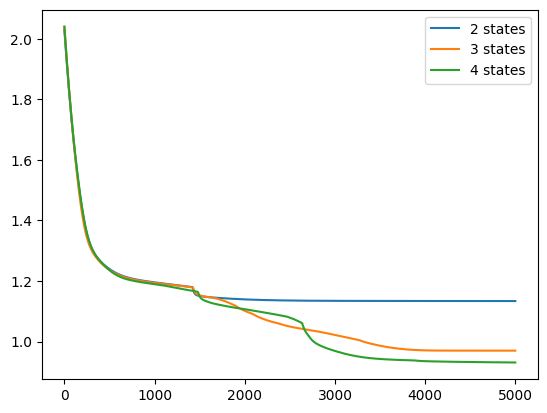

In [17]:
sns.lineplot(training_cache["CircHMM"][2].lps, label="2 states")
sns.lineplot(training_cache["CircHMM"][3].lps, label="3 states")
sns.lineplot(training_cache["CircHMM"][4].lps, label="4 states")

In [18]:
training_cache

Array([2.0404584, 2.0360305, 2.031616 , ..., 0.9309583, 0.9309559,
       0.9309536], dtype=float32)

In [19]:
training_cache["CircHMM"][4]

In [23]:
training_cache["CircHMM"][4].fit_params.transitions.transition_weights[0]

Array([[-0.23085745,  0.37730235,  0.28121665,  0.97430235,  1.4713405 ],
       [-0.7254634 ,  0.72348994, -0.45906   , -0.7803172 , -0.57019705],
       [-1.577803  , -1.6051687 , -1.6427596 , -1.6031122 , -1.6805452 ],
       [ 0.65423036, -1.2755809 ,  0.24850003, -0.21454309, -1.2671362 ]],      dtype=float32)

In [26]:
training_cache["CircHMM"][4].fit_params.emissions.weights

Array([[[ 2.83266187e-01,  1.07381800e-02, -6.40832484e-02,
          4.37593684e-02,  1.10763276e+00]],

       [[ 1.17694043e-01, -8.89237896e-02, -6.21083975e-02,
         -2.06562668e-01,  1.74767315e+00]],

       [[ 1.09972075e-01,  2.89706793e-02,  2.14026291e-02,
          1.42162833e-02,  6.28260374e-01]],

       [[ 3.66456471e-02,  2.39577387e-02,  8.37263884e-04,
          1.31549640e-02,  2.25558829e+00]]], dtype=float32)

In [27]:
training_cache["CircHMM"][4].fit_params.emissions.covs

Array([[[ 4.9348955]],

       [[ 1.9043467]],

       [[ 5.4074445]],

       [[40.73532  ]]], dtype=float32)

In [36]:
training_cache["CircHMM"][4].fit_model.emission_component.distribution(training_cache["CircHMM"][4].fit_params.emissions, 2)

TypeError: unsupported operand type(s) for @: 'ArrayImpl' and 'NoneType'